In [223]:
import pandas as pd
import datetime
import numpy as np
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle


In [4]:
flights_train = pd.read_csv("../data/flights_sample5pct.csv",low_memory=False)
flights_test = pd.read_csv("../data/flights_test.csv",low_memory=False)


### Predict the delay in the flight

In [3]:
flights_train.columns

Index(['Unnamed: 0', 'fl_date', 'mkt_unique_carrier', 'branded_code_share',
       'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [4]:
flights_test.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance'],
      dtype='object')

In [5]:
flights_train.groupby(['op_unique_carrier'])['dep_delay'].mean()


op_unique_carrier
9E    10.548736
9K    -2.285714
AA    11.047478
AS     3.716788
AX    19.565206
B6    16.833717
C5    26.502159
CP    10.586728
DL     7.769733
EM     4.564994
EV    13.987194
F9    17.512969
G4    12.235001
G7    14.274188
HA     0.956816
KS    18.915094
MQ     9.180366
NK    10.756339
OH    11.322264
OO    11.520783
PT     7.933663
QX     4.047369
UA    12.029859
VX     7.251790
WN    10.591095
YV    12.000643
YX     8.481504
ZW    11.723987
Name: dep_delay, dtype: float64

Keeping only columns in the test dataset and required columns for historical data for prediction in the training data

In [6]:
df_reg=flights_train[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance','dep_delay','arr_delay','carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay','cancelled']].copy()


In [7]:
df_reg

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_delay,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled
0,2018-09-20,DL,DL_CODESHARE,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",731,749,N,78.0,1,300,-8.0,-17.0,NaN,NaN,NaN,NaN,NaN,0
1,2018-09-20,DL,DL_CODESHARE,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",528,613,N,45.0,1,69,-11.0,-16.0,NaN,NaN,NaN,NaN,NaN,0
2,2018-09-20,DL,DL_CODESHARE,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,1309,N,84.0,1,320,-9.0,-13.0,NaN,NaN,NaN,NaN,NaN,0
3,2018-09-20,DL,DL_CODESHARE,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,1635,N,85.0,1,349,-7.0,-18.0,NaN,NaN,NaN,NaN,NaN,0
4,2018-09-20,DL,DL_CODESHARE,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,2229,N,39.0,1,69,57.0,73.0,0.0,0.0,16.0,0.0,57.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796323,2018-09-20,UA,UA_CODESHARE,UA,5853,OO,N144SY,5853,11503,EGE,"Eagle, CO",11292,DEN,"Denver, CO",1320,1423,N,63.0,1,120,-7.0,-17.0,NaN,NaN,NaN,NaN,NaN,0
796324,2018-09-20,UA,UA_CODESHARE,UA,5895,OO,N790SK,5895,12892,LAX,"Los Angeles, CA",10372,ASE,"Aspen, CO",950,1302,N,132.0,1,737,21.0,3.0,NaN,NaN,NaN,NaN,NaN,0
796325,2018-09-20,UA,UA_CODESHARE,UA,5913,OO,N119SY,5913,14869,SLC,"Salt Lake City, UT",11292,DEN,"Denver, CO",900,1037,N,97.0,1,391,-5.0,-14.0,NaN,NaN,NaN,NaN,NaN,0
796326,2018-09-20,UA,UA_CODESHARE,UA,5926,OO,N784SK,5926,13930,ORD,"Chicago, IL",11003,CID,"Cedar Rapids/Iowa City, IA",746,856,N,70.0,1,196,-8.0,12.0,NaN,NaN,NaN,NaN,NaN,0


In [8]:
missing_columns = df_reg.isnull().sum().sort_values(ascending=False)
missing_columns

late_aircraft_delay    645775
security_delay         645775
nas_delay              645775
weather_delay          645775
carrier_delay          645775
arr_delay               15508
dep_delay               13147
tail_num                 2514
crs_elapsed_time            2
fl_date                     0
crs_arr_time                0
distance                    0
flights                     0
dup                         0
crs_dep_time                0
mkt_unique_carrier          0
dest_city_name              0
dest                        0
dest_airport_id             0
origin_city_name            0
origin                      0
origin_airport_id           0
op_carrier_fl_num           0
op_unique_carrier           0
mkt_carrier_fl_num          0
mkt_carrier                 0
branded_code_share          0
cancelled                   0
dtype: int64

In [10]:
df_reg = df_reg[df_reg.dep_delay.notnull()]
df_reg = df_reg[df_reg.arr_delay.notnull()]

In [11]:
df_test=flights_test.copy()

In [12]:
df_reg=df_reg.sort_values(by=['op_unique_carrier'])
df_test=df_test.sort_values(by=['op_unique_carrier'])


In [5]:
def convert_time(df):
    
    df.fl_date = pd.to_datetime(df.fl_date, format='%Y-%m-%d')

    df['month'] = pd.DatetimeIndex(df.fl_date).month

    df['day'] = pd.DatetimeIndex(df.fl_date).day

    df['day_of_year'] = df.fl_date.dt.dayofyear

    df['day_of_week'] = df.fl_date.dt.dayofweek

    df['crs_dep_time'] = df['crs_dep_time'].apply(lambda x: '{0:0>4}'.format(x))
    df['crs_arr_time'] = df['crs_arr_time'].apply(lambda x: '{0:0>4}'.format(x))

    df['dep_hour'] = df['crs_dep_time'].str[:2]
    df['arr_hour'] = df['crs_arr_time'].str[:2]

    return df

In [14]:
df_reg=convert_time(df_reg)
df_reg.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_delay,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,month,day,day_of_year,day_of_week,dep_hour,arr_hour
243025,2018-01-28,DL,DL_CODESHARE,DL,3663,9E,N8970D,3663,14524,RIC,"Richmond, VA",12478,JFK,"New York, NY",1159,1321,N,82.0,1,288,139.0,156.0,0.0,0.0,17.0,0.0,139.0,0,1,28,28,6,11,13
597115,2018-10-15,DL,DL_CODESHARE,DL,5334,9E,N925XJ,5334,11193,CVG,"Cincinnati, OH",14492,RDU,"Raleigh/Durham, NC",0730,0856,N,86.0,1,390,-9.0,-20.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,07,08
597116,2018-10-15,DL,DL_CODESHARE,DL,5370,9E,N981EV,5370,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1342,1427,N,45.0,1,83,16.0,20.0,4.0,0.0,4.0,0.0,12.0,0,10,15,288,0,13,14
597117,2018-10-15,DL,DL_CODESHARE,DL,5429,9E,N840AY,5429,13931,ORF,"Norfolk, VA",12953,LGA,"New York, NY",1227,1355,N,88.0,1,296,-6.0,-1.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,12,13
597118,2018-10-15,DL,DL_CODESHARE,DL,5433,9E,N330PQ,5433,14633,RST,"Rochester, MN",10397,ATL,"Atlanta, GA",1450,1803,N,133.0,1,831,-8.0,-7.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,14,18


In [6]:
def bins(df):
    hours = {'00':0,'01':0,'02':0,'03':0,'04':0,'05':0,'06':1,'07':1,'08':1,'09':1,'10':1,'11':2,'12':2,'13':2,'14':2,'15':2,'16':2,'17':3,'18':3,'19':3,'20':4,'21':4,'22':4,'23':4,'24': 4}
    df['dep_part_day'] = df['dep_hour'].map(hours)
    df['arr_part_day'] = df['arr_hour'].map(hours)
    season = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
    df['season'] = df['month'].map(season)
    
    return df



In [16]:
df_reg=bins(df_reg)
df_reg.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_delay,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season
243025,2018-01-28,DL,DL_CODESHARE,DL,3663,9E,N8970D,3663,14524,RIC,"Richmond, VA",12478,JFK,"New York, NY",1159,1321,N,82.0,1,288,139.0,156.0,0.0,0.0,17.0,0.0,139.0,0,1,28,28,6,11,13,2,2,1
597115,2018-10-15,DL,DL_CODESHARE,DL,5334,9E,N925XJ,5334,11193,CVG,"Cincinnati, OH",14492,RDU,"Raleigh/Durham, NC",0730,0856,N,86.0,1,390,-9.0,-20.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,07,08,1,1,4
597116,2018-10-15,DL,DL_CODESHARE,DL,5370,9E,N981EV,5370,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1342,1427,N,45.0,1,83,16.0,20.0,4.0,0.0,4.0,0.0,12.0,0,10,15,288,0,13,14,2,2,4
597117,2018-10-15,DL,DL_CODESHARE,DL,5429,9E,N840AY,5429,13931,ORF,"Norfolk, VA",12953,LGA,"New York, NY",1227,1355,N,88.0,1,296,-6.0,-1.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,12,13,2,2,4
597118,2018-10-15,DL,DL_CODESHARE,DL,5433,9E,N330PQ,5433,14633,RST,"Rochester, MN",10397,ATL,"Atlanta, GA",1450,1803,N,133.0,1,831,-8.0,-7.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,14,18,2,3,4


In [17]:
df_test=convert_time(df_test)
df_test=bins(df_test)
df_test

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season
660555,2020-01-31,DL,DL_CODESHARE,DL,4958,9E,N390CA,4958,12953,LGA,"New York, NY",11057,CLT,"Charlotte, NC",2005,2222,N,137,1,544,1,31,31,4,20,22,4,4,1
207958,2020-01-10,DL,DL_CODESHARE,DL,5347,9E,N301PQ,5347,13487,MSP,"Minneapolis, MN",11423,DSM,"Des Moines, IA",1445,1608,N,83,1,232,1,10,10,4,14,16,2,2,1
207959,2020-01-10,DL,DL_CODESHARE,DL,5348,9E,N8869B,5348,12953,LGA,"New York, NY",10990,CHO,"Charlottesville, VA",1829,2008,N,99,1,305,1,10,10,4,18,20,3,4,1
207960,2020-01-10,DL,DL_CODESHARE,DL,5350,9E,N146PQ,5350,12448,JAN,"Jackson/Vicksburg, MS",10397,ATL,"Atlanta, GA",0700,0927,N,87,1,341,1,10,10,4,07,09,1,1,1
207961,2020-01-10,DL,DL_CODESHARE,DL,5352,9E,N8974C,5352,10581,BGR,"Bangor, ME",12953,LGA,"New York, NY",1117,1314,N,117,1,378,1,10,10,4,11,13,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277382,2020-01-13,UA,UA_CODESHARE,UA,3908,ZW,N420AW,3908,10792,BUF,"Buffalo, NY",12264,IAD,"Washington, DC",1445,1608,N,83,1,283,1,13,13,0,14,16,2,2,1
277381,2020-01-13,UA,UA_CODESHARE,UA,3909,ZW,N430AW,3909,13930,ORD,"Chicago, IL",11042,CLE,"Cleveland, OH",0915,1142,N,87,1,315,1,13,13,0,09,11,1,2,1
277380,2020-01-13,UA,UA_CODESHARE,UA,3910,ZW,N455AW,3910,13930,ORD,"Chicago, IL",14524,RIC,"Richmond, VA",1145,1452,N,127,1,642,1,13,13,0,11,14,2,2,1
277378,2020-01-13,UA,UA_CODESHARE,UA,3912,ZW,N448AW,3912,13930,ORD,"Chicago, IL",11612,EVV,"Evansville, IN",1545,1704,N,79,1,272,1,13,13,0,15,17,2,3,1


In [18]:
def stats_history(df):
    #mean carrier delay
    df['mean_carrier_dep_delay'] = df.groupby(['op_unique_carrier'])['dep_delay'].transform(np.mean)
    df['mean_carrier_arr_delay'] = df.groupby(['op_unique_carrier'])['arr_delay'].transform(np.mean)
    #mean and median carrier delay per month
    df['mean_carrier_dep_delay_month'] = df.groupby(['op_unique_carrier','month'])['dep_delay'].transform(np.mean)
    df['mean_carrier_arr_delay_month'] = df.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.mean)
    df['median_carrier_dep_delay_month'] = df.groupby(['op_unique_carrier','month'])['dep_delay'].transform(np.median)
    df['median_carrier_arr_delay_month'] = df.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.median)
    #mean and median carrier delay per origin (dest) and time dephour for origin and arrhour for destination
    df['mean_carrier_origin_hour_dep_delay']=df.groupby(['op_unique_carrier','origin','dep_hour'])['dep_delay'].transform(np.mean)
    df['median_carrier_origin_hour_dep_delay']=df.groupby(['op_unique_carrier','origin','dep_hour'])['dep_delay'].transform(np.median)
    df['mean_carrier_dest_hour_arr_delay']=df.groupby(['op_unique_carrier','origin','arr_hour'])['arr_delay'].transform(np.mean)
    df['median_carrier_dest_hour_arr_delay']=df.groupby(['op_unique_carrier','origin','arr_hour'])['arr_delay'].transform(np.median)
    #mean and median carrier delay per route (origin-dest) per month,day of the week, part of the day
    df['mean_carrier_route_month_dow_part_dep_delay'] = df.groupby(['op_unique_carrier','origin','dest','month','day_of_week','dep_part_day'])['dep_delay'].transform(np.mean)
    df['median_carrier_route_month_dow_part_dep_delay'] = df.groupby(['op_unique_carrier','origin','dest','month','day_of_week','dep_part_day'])['dep_delay'].transform(np.median)
    df['mean_carrier_route_month_dow_part_arr_delay'] = df.groupby(['op_unique_carrier','origin','dest','month','day_of_week','arr_part_day'])['arr_delay'].transform(np.mean)
    df['median_carrier_route_month_dow_part_arr_delay'] = df.groupby(['op_unique_carrier','origin','dest','month','day_of_week','arr_part_day'])['arr_delay'].transform(np.median)
    #mean and median carrier delay for route and dep & arr delay for month, day of week, dephour,arrhour
    df['mean_route_dep_delay_month']=df.groupby(['origin','dest', 'month'])['dep_delay'].transform(np.mean)
    df['mean_route_dep_delay_dow']=df.groupby(['origin','dest', 'day_of_week'])['dep_delay'].transform(np.mean)
    df['mean_route_dep_delay_dep_hour']=df.groupby(['origin','dest', 'dep_hour'])['dep_delay'].transform(np.mean)
    df['mean_route_dep_delay_arr_hour']=df.groupby(['origin','dest', 'arr_hour'])['dep_delay'].transform(np.mean)
    df['mean_route_arr_delay_month']=df.groupby(['origin','dest', 'month'])['arr_delay'].transform(np.mean)
    df['mean_route_arr_delay_dow']=df.groupby(['origin','dest', 'day_of_week'])['arr_delay'].transform(np.mean)
    df['mean_route_arr_delay_dep_hour']=df.groupby(['origin','dest', 'dep_hour'])['arr_delay'].transform(np.mean)
    df['mean_route_arr_delay_arr_hour']=df.groupby(['origin','dest', 'arr_hour'])['arr_delay'].transform(np.mean)
    df['median_route_dep_delay_month']=df.groupby(['origin','dest', 'month'])['dep_delay'].transform(np.median)
    df['median_route_dep_delay_dow']=df.groupby(['origin','dest', 'day_of_week'])['dep_delay'].transform(np.median)
    df['median_route_dep_delay_dep_hour']=df.groupby(['origin','dest', 'dep_hour'])['dep_delay'].transform(np.median)
    df['median_route_dep_delay_arr_hour']=df.groupby(['origin','dest', 'arr_hour'])['dep_delay'].transform(np.median)
    df['median_route_arr_delay_month']=df.groupby(['origin','dest', 'month'])['arr_delay'].transform(np.median)
    df['median_route_arr_delay_dow']=df.groupby(['origin','dest', 'day_of_week'])['arr_delay'].transform(np.median)
    df['median_route_arr_delay_dep_hour']=df.groupby(['origin','dest', 'dep_hour'])['arr_delay'].transform(np.median)
    df['median_route_arr_delay_arr_hour']=df.groupby(['origin','dest', 'arr_hour'])['arr_delay'].transform(np.median)
    
    historical_data=df.filter(['mean_carrier_dep_delay', 'mean_carrier_arr_delay',
       'mean_carrier_dep_delay_month', 'mean_carrier_arr_delay_month',
       'median_carrier_dep_delay_month', 'median_carrier_arr_delay_month',
       'mean_carrier_origin_hour_dep_delay',
       'median_carrier_origin_hour_dep_delay',
       'mean_carrier_dest_hour_arr_delay',
       'median_carrier_dest_hour_arr_delay',
       'mean_carrier_route_month_dow_part_dep_delay',
       'median_carrier_route_month_dow_part_dep_delay',
       'mean_carrier_route_month_dow_part_arr_delay',
       'median_carrier_route_month_dow_part_arr_delay',
       'mean_route_dep_delay_month', 'mean_route_dep_delay_dow',
       'mean_route_dep_delay_dep_hour', 'mean_route_dep_delay_arr_hour',
       'mean_route_arr_delay_month', 'mean_route_arr_delay_dow',
       'mean_route_arr_delay_dep_hour', 'mean_route_arr_delay_arr_hour',
       'median_route_dep_delay_month', 'median_route_dep_delay_dow',
       'median_route_dep_delay_dep_hour', 'median_route_dep_delay_arr_hour',
       'median_route_arr_delay_month', 'median_route_arr_delay_dow',
       'median_route_arr_delay_dep_hour', 'median_route_arr_delay_arr_hour'])
    return historical_data


In [19]:
hist=stats_history(df_reg)
hist.head()

,mean_carrier_dep_delay,mean_carrier_arr_delay,mean_carrier_dep_delay_month,mean_carrier_arr_delay_month,median_carrier_dep_delay_month,median_carrier_arr_delay_month,mean_carrier_origin_hour_dep_delay,median_carrier_origin_hour_dep_delay,mean_carrier_dest_hour_arr_delay,median_carrier_dest_hour_arr_delay,mean_carrier_route_month_dow_part_dep_delay,median_carrier_route_month_dow_part_dep_delay,mean_carrier_route_month_dow_part_arr_delay,median_carrier_route_month_dow_part_arr_delay,mean_route_dep_delay_month,mean_route_dep_delay_dow,mean_route_dep_delay_dep_hour,mean_route_dep_delay_arr_hour,mean_route_arr_delay_month,mean_route_arr_delay_dow,mean_route_arr_delay_dep_hour,mean_route_arr_delay_arr_hour,median_route_dep_delay_month,median_route_dep_delay_dow,median_route_dep_delay_dep_hour,median_route_dep_delay_arr_hour,median_route_arr_delay_month,median_route_arr_delay_dow,median_route_arr_delay_dep_hour,median_route_arr_delay_arr_hour
243025,10.488755,3.904799,11.309524,3.370432,-4.0,-11.0,53.882353,-2.5,34.022727,-12.0,139.0,139.0,156.0,156.0,14.714286,28.500000,53.258065,51.281250,11.000000,24.428571,48.000000,45.343750,-5.0,-3.5,-3.0,-3.5,-10.0,-2.5,-11.0,-11.5
597115,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,1.115207,-4.0,-4.688623,-11.0,-9.0,-9.0,-20.0,-20.0,1.857143,0.666667,-1.000000,-2.714286,-3.285714,-0.500000,-2.675676,-3.942857,-6.0,-6.5,-3.0,-3.0,-13.0,-6.0,-8.0,-9.0
597116,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,5.659004,-3.0,1.114679,-7.0,16.0,16.0,20.0,20.0,10.000000,9.521739,12.680000,12.000000,6.666667,7.260870,9.440000,8.615385,-4.0,-4.0,-2.0,-2.5,-9.0,-5.0,-5.0,-5.0
597117,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,3.344828,-5.0,15.956522,-7.0,-6.0,-6.0,-1.0,-1.0,3.172414,14.155556,6.242424,23.285714,1.137931,5.355556,4.818182,22.285714,-6.0,-4.0,-5.0,-4.0,-10.0,-13.0,-7.0,-5.0
597118,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,5.000000,5.0,42.666667,54.0,-8.0,-8.0,-7.0,-7.0,-6.000000,16.200000,1.666667,14.200000,-9.666667,18.600000,12.666667,20.800000,-5.0,1.0,-5.0,-5.0,-7.0,-6.0,-7.0,-7.0


In [20]:
hist.shape

(780600, 30)

In [21]:
df_reg=pd.concat((df_reg,hist), axis=1)
df_reg.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,dep_delay,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season,mean_carrier_dep_delay,mean_carrier_arr_delay,mean_carrier_dep_delay_month,mean_carrier_arr_delay_month,median_carrier_dep_delay_month,median_carrier_arr_delay_month,mean_carrier_origin_hour_dep_delay,median_carrier_origin_hour_dep_delay,mean_carrier_dest_hour_arr_delay,median_carrier_dest_hour_arr_delay,mean_carrier_route_month_dow_part_dep_delay,median_carrier_route_month_dow_part_dep_delay,mean_carrier_route_month_dow_part_arr_delay,median_carrier_route_month_dow_part_arr_delay,mean_route_dep_delay_month,mean_route_dep_delay_dow,mean_route_dep_delay_dep_hour,mean_route_dep_delay_arr_hour,mean_route_arr_delay_month,mean_route_arr_delay_dow,mean_route_arr_delay_dep_hour,mean_route_arr_delay_arr_hour,median_route_dep_delay_month,median_route_dep_delay_dow,median_route_dep_delay_dep_hour,median_route_dep_delay_arr_hour,median_route_arr_delay_month,median_route_arr_delay_dow,median_route_arr_delay_dep_hour,median_route_arr_delay_arr_hour,mean_carrier_dep_delay,mean_carrier_arr_delay,mean_carrier_dep_delay_month,mean_carrier_arr_delay_month,median_carrier_dep_delay_month,median_carrier_arr_delay_month,mean_carrier_origin_hour_dep_delay,median_carrier_origin_hour_dep_delay,mean_carrier_dest_hour_arr_delay,median_carrier_dest_hour_arr_delay,mean_carrier_route_month_dow_part_dep_delay,median_carrier_route_month_dow_part_dep_delay,mean_carrier_route_month_dow_part_arr_delay,median_carrier_route_month_dow_part_arr_delay,mean_route_dep_delay_month,mean_route_dep_delay_dow,mean_route_dep_delay_dep_hour,mean_route_dep_delay_arr_hour,mean_route_arr_delay_month,mean_route_arr_delay_dow,mean_route_arr_delay_dep_hour,mean_route_arr_delay_arr_hour,median_route_dep_delay_month,median_route_dep_delay_dow,median_route_dep_delay_dep_hour,median_route_dep_delay_arr_hour,median_route_arr_delay_month,median_route_arr_delay_dow,median_route_arr_delay_dep_hour,median_route_arr_delay_arr_hour
243025,2018-01-28,DL,DL_CODESHARE,DL,3663,9E,N8970D,3663,14524,RIC,"Richmond, VA",12478,JFK,"New York, NY",1159,1321,N,82.0,1,288,139.0,156.0,0.0,0.0,17.0,0.0,139.0,0,1,28,28,6,11,13,2,2,1,10.488755,3.904799,11.309524,3.370432,-4.0,-11.0,53.882353,-2.5,34.022727,-12.0,139.0,139.0,156.0,156.0,14.714286,28.500000,53.258065,51.281250,11.000000,24.428571,48.000000,45.343750,-5.0,-3.5,-3.0,-3.5,-10.0,-2.5,-11.0,-11.5,10.488755,3.904799,11.309524,3.370432,-4.0,-11.0,53.882353,-2.5,34.022727,-12.0,139.0,139.0,156.0,156.0,14.714286,28.500000,53.258065,51.281250,11.000000,24.428571,48.000000,45.343750,-5.0,-3.5,-3.0,-3.5,-10.0,-2.5,-11.0,-11.5
597115,2018-10-15,DL,DL_CODESHARE,DL,5334,9E,N925XJ,5334,11193,CVG,"Cincinnati, OH",14492,RDU,"Raleigh/Durham, NC",0730,0856,N,86.0,1,390,-9.0,-20.0,NaN,NaN,NaN,NaN,NaN,0,10,15,288,0,07,08,1,1,4,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,1.115207,-4.0,-4.688623,-11.0,-9.0,-9.0,-20.0,-20.0,1.857143,0.666667,-1.000000,-2.714286,-3.285714,-0.500000,-2.675676,-3.942857,-6.0,-6.5,-3.0,-3.0,-13.0,-6.0,-8.0,-9.0,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,1.115207,-4.0,-4.688623,-11.0,-9.0,-9.0,-20.0,-20.0,1.857143,0.666667,-1.000000,-2.714286,-3.285714,-0.500000,-2.675676,-3.942857,-6.0,-6.5,-3.0,-3.0,-13.0,-6.0,-8.0,-9.0
597116,2018-10-15,DL,DL_CODESHARE,DL,5370,9E,N981EV,5370,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1342,1427,N,45.0,1,83,16.0,20.0,4.0,0.0,4.0,0.0,12.0,0,10,15,288,0,13,14,2,2,4,10.488755,3.904799,5.070847,-0.059837,-5.0,-9.0,5.659004,-3.0,1.114679,-7.0,16.0,16.0,20.0,20.0,10.000000,9.521739,12.680000,12.000000,6.666667,7.260870,9.440000,8.615385,-4.0,-4.0,-2.0,

In [22]:
df_test=pd.concat((df_test,hist),axis=1)
df_test.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season,mean_carrier_dep_delay,mean_carrier_arr_delay,mean_carrier_dep_delay_month,mean_carrier_arr_delay_month,median_carrier_dep_delay_month,median_carrier_arr_delay_month,mean_carrier_origin_hour_dep_delay,median_carrier_origin_hour_dep_delay,mean_carrier_dest_hour_arr_delay,median_carrier_dest_hour_arr_delay,mean_carrier_route_month_dow_part_dep_delay,median_carrier_route_month_dow_part_dep_delay,mean_carrier_route_month_dow_part_arr_delay,median_carrier_route_month_dow_part_arr_delay,mean_route_dep_delay_month,mean_route_dep_delay_dow,mean_route_dep_delay_dep_hour,mean_route_dep_delay_arr_hour,mean_route_arr_delay_month,mean_route_arr_delay_dow,mean_route_arr_delay_dep_hour,mean_route_arr_delay_arr_hour,median_route_dep_delay_month,median_route_dep_delay_dow,median_route_dep_delay_dep_hour,median_route_dep_delay_arr_hour,median_route_arr_delay_month,median_route_arr_delay_dow,median_route_arr_delay_dep_hour,median_route_arr_delay_arr_hour
660555,2020-01-31,DL,DL_CODESHARE,DL,4958.0,9E,N390CA,4958.0,12953.0,LGA,"New York, NY",11057.0,CLT,"Charlotte, NC",2005,2222,N,137.0,1.0,544.0,1.0,31.0,31.0,4.0,20,22,4.0,4.0,1.0,10.595378,6.413569,5.869732,2.025543,-5.0,-9.0,11.709220,-4.0,5.575342,-6.0,-4.0,-4.0,-15.0,-15.0,2.789474,4.633094,9.516667,5.662162,-3.671053,1.280576,3.366667,1.324324,-3.5,-2.0,-2.0,-3.0,-9.0,-4.0,-6.0,-7.0
207958,2020-01-10,DL,DL_CODESHARE,DL,5347.0,9E,N301PQ,5347.0,13487.0,MSP,"Minneapolis, MN",11423.0,DSM,"Des Moines, IA",1445,1608,N,83.0,1.0,232.0,1.0,10.0,10.0,4.0,14,16,2.0,2.0,1.0,10.569316,3.466100,12.854908,6.108106,0.0,-4.0,17.623457,2.0,4.358974,-7.0,14.0,14.0,9.0,9.0,14.947368,5.391304,11.666667,5.352941,7.105263,-1.347826,6.800000,-1.058824,-1.0,-1.0,3.0,2.0,-5.0,-5.5,-3.0,-9.0
207959,2020-01-10,DL,DL_CODESHARE,DL,5348.0,9E,N8869B,5348.0,12953.0,LGA,"New York, NY",10990.0,CHO,"Charlottesville, VA",1829,2008,N,99.0,1.0,305.0,1.0,10.0,10.0,4.0,18,20,3.0,4.0,1.0,10.569316,3.466100,12.854908,6.108106,0.0,-4.0,1.312500,-2.0,-4.324176,-7.0,-3.0,-3.0,-11.0,-11.0,1.000000,-2.272727,4.500000,4.500000,-8.000000,-8.454545,2.500000,2.500000,1.0,-3.0,2.0,2.0,-8.0,-9.0,-3.5,-3.5
207960,2020-01-10,DL,DL_CODESHARE,DL,5350.0,9E,N146PQ,5350.0,12448.0,JAN,"Jackson/Vicksburg, MS",10397.0,ATL,"Atlanta, GA",0700,0927,N,87.0,1.0,341.0,1.0,10.0,10.0,4.0,07,09,1.0,1.0,1.0,10.569316,3.466100,12.854908,6.108106,0.0,-4.0,8.687117,0.0,1.668966,-3.0,-2.0,-2.0,-6.0,-6.0,0.222222,10.684211,4.964286,4.964286,-5.777778,3.947368,-1.428571,-1.428571,0.0,-1.0,1.5,1.5,-6.0,-4.0,-3.0,-3.0
207961,2020-01-10,DL,DL_CODESHARE,DL,5352.0,9E,N8974C,5352.0,10581.0,BGR,"Bangor, ME",12953.0,LGA,"New York, NY",1117,1314,N,117.0,1.0,378.0,1.0,10.0,10.0,4.0,11,13,2.0,2.0,1.0,10.569316,3.466100,12.854908,6.108106,0.0,-4.0,20.293023,6.0,12.811594,2.0,62.0,62.0,48.0,48.0,20.785714,11.903846,20.052632,24.360000,15.333333,5.576923,11.842105,15.400000,6.0,1.5,6.0,18.0,-0.5,-2.0,-1.0,8.0


In [23]:
df_dummy = pd.get_dummies(df_reg[["op_unique_carrier"]])
df_reg = pd.concat([df_reg,df_dummy],axis=1).drop(["op_unique_carrier",'op_unique_carrier_9E'],axis=1)


In [24]:
df_reg.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name',
       ...
       'op_unique_carrier_OH', 'op_unique_carrier_OO', 'op_unique_carrier_PT',
       'op_unique_carrier_QX', 'op_unique_carrier_UA', 'op_unique_carrier_VX',
       'op_unique_carrier_WN', 'op_unique_carrier_YV', 'op_unique_carrier_YX',
       'op_unique_carrier_ZW'],
      dtype='object', length=123)

In [25]:
dfr = df_reg.select_dtypes('number').dropna(axis='columns')
dfr.columns

Index(['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id',
       'dest_airport_id', 'crs_elapsed_time', 'flights', 'distance',
       'dep_delay', 'arr_delay', 'cancelled',
       ...
       'op_unique_carrier_OH', 'op_unique_carrier_OO', 'op_unique_carrier_PT',
       'op_unique_carrier_QX', 'op_unique_carrier_UA', 'op_unique_carrier_VX',
       'op_unique_carrier_WN', 'op_unique_carrier_YV', 'op_unique_carrier_YX',
       'op_unique_carrier_ZW'],
      dtype='object', length=104)

In [26]:
missing_values = dfr.isnull().sum().sort_values(ascending=False)
missing_values

mkt_carrier_fl_num                               0
op_carrier_fl_num                                0
median_route_arr_delay_arr_hour                  0
median_route_arr_delay_dep_hour                  0
median_route_arr_delay_dow                       0
                                                ..
mean_route_dep_delay_month                       0
median_carrier_route_month_dow_part_arr_delay    0
mean_carrier_route_month_dow_part_arr_delay      0
median_carrier_route_month_dow_part_dep_delay    0
op_unique_carrier_ZW                             0
Length: 104, dtype: int64

In [27]:
dfr=dfr.reset_index()

In [28]:
X=dfr[[
       'mean_carrier_dep_delay', 'mean_carrier_arr_delay',
       'mean_carrier_dep_delay_month', 'mean_carrier_arr_delay_month',
       'median_carrier_dep_delay_month', 'median_carrier_arr_delay_month',
       'mean_carrier_origin_hour_dep_delay',
       'median_carrier_origin_hour_dep_delay',
       'mean_carrier_dest_hour_arr_delay',
       'median_carrier_dest_hour_arr_delay',
       'mean_carrier_route_month_dow_part_dep_delay',
       'median_carrier_route_month_dow_part_dep_delay',
       'mean_carrier_route_month_dow_part_arr_delay',
       'median_carrier_route_month_dow_part_arr_delay',
       'mean_route_dep_delay_month', 'mean_route_dep_delay_dow',
       'mean_route_dep_delay_dep_hour', 'mean_route_dep_delay_arr_hour',
       'mean_route_arr_delay_month', 'mean_route_arr_delay_dow',
       'mean_route_arr_delay_dep_hour', 'mean_route_arr_delay_arr_hour',
       'median_route_dep_delay_month', 'median_route_dep_delay_dow',
       'median_route_dep_delay_dep_hour', 'median_route_dep_delay_arr_hour',
       'median_route_arr_delay_month', 'median_route_arr_delay_dow',
       'median_route_arr_delay_dep_hour', 'median_route_arr_delay_arr_hour',
       'op_unique_carrier_9K', 'op_unique_carrier_AA', 'op_unique_carrier_AS',
       'op_unique_carrier_AX', 'op_unique_carrier_B6', 'op_unique_carrier_C5',
       'op_unique_carrier_CP', 'op_unique_carrier_DL', 'op_unique_carrier_EM',
       'op_unique_carrier_EV', 'op_unique_carrier_F9', 'op_unique_carrier_G4',
       'op_unique_carrier_G7', 'op_unique_carrier_HA', 'op_unique_carrier_KS',
       'op_unique_carrier_MQ', 'op_unique_carrier_NK', 'op_unique_carrier_OH',
       'op_unique_carrier_OO', 'op_unique_carrier_PT', 'op_unique_carrier_QX',
       'op_unique_carrier_UA', 'op_unique_carrier_VX', 'op_unique_carrier_WN',
       'op_unique_carrier_YV', 'op_unique_carrier_YX', 'op_unique_carrier_ZW']].copy()

In [29]:
y = dfr.arr_delay


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=9)

In [162]:
lr=LinearRegression()
lr_train=lr.fit(X_train,y_train)

In [163]:
r_sq = lr_train.score(X_train,y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8289090139429198


In [164]:
y_pred_lr=lr_train.predict(X_valid)

In [165]:
r2_score(y_valid,y_pred_lr)

0.8257502630402571

In [192]:
pickle.dump(lr_train, open('../models/lr_reg.pkl', 'wb'))


In [166]:
rf = RandomForestRegressor(n_estimators=60, max_depth=6, random_state=10)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, n_estimators=60, random_state=10)

In [167]:
r_sq_rf = rf.score(X_train,y_train)
print('coefficient of determination:', r_sq_rf)

coefficient of determination: 0.8432294022920831


In [168]:
y_pred_rf=rf.predict(X_valid)
r2_score(y_valid,y_pred_rf)

0.8217344577064165

In [193]:
pickle.dump(rf, open('../models/rf_reg.pkl', 'wb'))


### To predict the cancellation of the flight

In [7]:
flights_train.columns

Index(['Unnamed: 0', 'fl_date', 'mkt_unique_carrier', 'branded_code_share',
       'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [176]:
df_clf=flights_train[['fl_date', 'mkt_unique_carrier', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time','dep_delay',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance','arr_delay','carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay','cancelled','cancellation_code','total_add_gtime',
       'longest_add_gtime']].copy()

In [221]:
df_clf['cancelled'].value_counts()

0    782924
1     13404
Name: cancelled, dtype: int64

In [177]:
missing_values= df_clf.isnull().sum().sort_values(ascending=False)
missing_values

longest_add_gtime      790882
total_add_gtime        790882
cancellation_code      782924
late_aircraft_delay    645775
security_delay         645775
nas_delay              645775
weather_delay          645775
carrier_delay          645775
arr_delay               15508
dep_delay               13147
tail_num                 2514
crs_elapsed_time            2
dup                         0
cancelled                   0
distance                    0
flights                     0
fl_date                     0
mkt_unique_carrier          0
crs_dep_time                0
dest_city_name              0
dest                        0
dest_airport_id             0
origin_city_name            0
origin                      0
origin_airport_id           0
op_carrier_fl_num           0
op_unique_carrier           0
mkt_carrier_fl_num          0
mkt_carrier                 0
crs_arr_time                0
dtype: int64

In [178]:
df_clf=convert_time(df_clf)
df_clf=bins(df_clf)

df_clf.head()

,fl_date,mkt_unique_carrier,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,cancellation_code,total_add_gtime,longest_add_gtime,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season
0,2018-09-20,DL,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",0731,-8.0,0749,N,78.0,1,300,-17.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,07,07,1,1,4
1,2018-09-20,DL,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",0528,-11.0,0613,N,45.0,1,69,-16.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,05,06,0,1,4
2,2018-09-20,DL,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,-9.0,1309,N,84.0,1,320,-13.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,11,13,2,2,4
3,2018-09-20,DL,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,-7.0,1635,N,85.0,1,349,-18.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,15,16,2,2,4
4,2018-09-20,DL,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,NaN,NaN,NaN,9,20,263,3,21,22,4,4,4


In [179]:
#cancellations by carrier, date (day,hour,season),origin & dest, route, volume at origin & destination, volume airline operates
def stats_hist_cancel(df):
   # df['origin_airport_vol'] = df.groupby(['origin_airport_id'])['flights'].transform(np.sum)
   # df['dest_airport_vol'] = df.groupby(['dest_airport_id'])['flights'].transform(np.sum)
    df['carrier_origin_vol'] = df.groupby(['origin_airport_id','op_unique_carrier'])['flights'].transform(np.sum)
    df['carrier_dest_vol'] = df.groupby(['dest_airport_id','op_unique_carrier'])['flights'].transform(np.sum)

   # df['carrier_origin'] = df['carrier_origin_vol'] / df['origin_airport_vol'] * 100
   # df['carrier_dest'] = df['carrier_dest_vol'] / df['dest_airport_vol'] * 100
    df['carrier_cancel'] = df.groupby(['op_unique_carrier'])['cancelled'].transform(np.sum) / df.groupby(['op_unique_carrier'])['flights'].transform(np.sum) * 100
    df['carrier_month_cancel'] = df.groupby(['month'])['cancelled'].transform(np.sum) / df.groupby(['month'])['flights'].transform(np.sum) * 100
    #df['carrier_dow_cancel'] = df.groupby(['day_of_week'])['cancelled'].transform(np.sum) / df.groupby(['day_of_week'])['flights'].transform(np.sum) * 100
   # df['carrier_dep_part_day_cancel'] = df.groupby(['dep_part_day'])['cancelled'].transform(np.sum) / df.groupby(['dep_part_day'])['flights'].transform(np.sum) * 100
    df['carrier_season_cancel'] = df.groupby(['season'])['cancelled'].transform(np.sum) / df.groupby(['season'])['flights'].transform(np.sum) * 100
    df['carrier_dep_hour_cancel'] = df.groupby(['dep_hour'])['cancelled'].transform(np.sum) / df.groupby(['dep_hour'])['flights'].transform(np.sum) * 100
    df['origin_cancel'] = df.groupby(['origin'])['cancelled'].transform(np.sum) / df.groupby(['origin'])['flights'].transform(np.sum) * 100
    df['dest_cancel'] = df.groupby(['dest'])['cancelled'].transform(np.sum) / df.groupby(['dest'])['flights'].transform(np.sum) * 100
    df['route_cancel'] = df.groupby(['origin','dest'])['cancelled'].transform(np.sum) / df.groupby(['origin','dest'])['flights'].transform(np.sum) * 100
    df['origin_month_cancellation'] = df.groupby(['origin','month'])['cancelled'].transform(np.sum) / df.groupby(['origin','month'])['flights'].transform(np.sum) * 100
    df['dest_month_cancellation'] = df.groupby(['dest','month'])['cancelled'].transform(np.sum) / df.groupby(['dest','month'])['flights'].transform(np.sum) * 100
    df['route_month_cancellation'] = df.groupby(['origin','dest','month'])['cancelled'].transform(np.sum) / df.groupby(['origin','dest','month'])['flights'].transform(np.sum) * 100
    #cancel_hist=df[['carrier_cancel','carrier_month_cancel','carrier_dow_cancel','carrier_dep_part_day_cancel','carrier_season_cancel','carrier_dep_hour_cancel','origin_cancel','dest_cancel','route_cancel']]
    return df

In [180]:
#cancellation_history=stats_hist_cancel(df_clf)
df_clf=stats_hist_cancel(df_clf)

In [181]:
df_clf.head()

,fl_date,mkt_unique_carrier,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,cancellation_code,total_add_gtime,longest_add_gtime,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season,carrier_origin_vol,carrier_dest_vol,carrier_cancel,carrier_month_cancel,carrier_season_cancel,carrier_dep_hour_cancel,origin_cancel,dest_cancel,route_cancel,origin_month_cancellation,dest_month_cancellation,route_month_cancellation
0,2018-09-20,DL,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",0731,-8.0,0749,N,78.0,1,300,-17.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,07,07,1,1,4,120,4739,1.647405,1.576921,1.146655,1.386550,2.906977,0.807784,2.127660,0.0,0.231125,0.0
1,2018-09-20,DL,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",0528,-11.0,0613,N,45.0,1,69,-16.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,05,06,0,1,4,51,91,1.647405,1.576921,1.146655,2.174256,0.000000,2.197802,0.000000,0.0,0.000000,0.0
2,2018-09-20,DL,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,-9.0,1309,N,84.0,1,320,-13.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,11,13,2,2,4,111,4438,1.647405,1.576921,1.146655,1.229100,1.739130,0.414594,0.000000,0.0,0.096805,0.0
3,2018-09-20,DL,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,-7.0,1635,N,85.0,1,349,-18.0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,9,20,263,3,15,16,2,2,4,120,4214,1.647405,1.576921,1.146655,1.699526,2.906977,0.853037,4.109589,0.0,0.280112,0.0
4,2018-09-20,DL,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,NaN,NaN,NaN,9,20,263,3,21,22,4,4,4,107,67,1.647405,1.576921,1.146655,2.248487,1.869159,2.985075,0.000000,0.0,0.000000,0.0


In [182]:
df_clf.columns

Index(['fl_date', 'mkt_unique_carrier', 'mkt_carrier', 'mkt_carrier_fl_num',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_delay', 'crs_arr_time',
       'dup', 'crs_elapsed_time', 'flights', 'distance', 'arr_delay',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'cancelled', 'cancellation_code',
       'total_add_gtime', 'longest_add_gtime', 'month', 'day', 'day_of_year',
       'day_of_week', 'dep_hour', 'arr_hour', 'dep_part_day', 'arr_part_day',
       'season', 'carrier_origin_vol', 'carrier_dest_vol', 'carrier_cancel',
       'carrier_month_cancel', 'carrier_season_cancel',
       'carrier_dep_hour_cancel', 'origin_cancel', 'dest_cancel',
       'route_cancel', 'origin_month_cancellation', 'dest_month_cancellation',
       'route_month_cancellation'],
      dtype='object')

In [183]:
df_clf = df_clf.select_dtypes('number').dropna(axis='columns')
df_clf.columns


Index(['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id',
       'dest_airport_id', 'flights', 'distance', 'cancelled', 'month', 'day',
       'day_of_year', 'day_of_week', 'dep_part_day', 'arr_part_day', 'season',
       'carrier_origin_vol', 'carrier_dest_vol', 'carrier_cancel',
       'carrier_month_cancel', 'carrier_season_cancel',
       'carrier_dep_hour_cancel', 'origin_cancel', 'dest_cancel',
       'route_cancel', 'origin_month_cancellation', 'dest_month_cancellation',
       'route_month_cancellation'],
      dtype='object')

In [184]:
missing_values= df_clf.isnull().sum().sort_values(ascending=False)
missing_values

mkt_carrier_fl_num           0
op_carrier_fl_num            0
dest_month_cancellation      0
origin_month_cancellation    0
route_cancel                 0
dest_cancel                  0
origin_cancel                0
carrier_dep_hour_cancel      0
carrier_season_cancel        0
carrier_month_cancel         0
carrier_cancel               0
carrier_dest_vol             0
carrier_origin_vol           0
season                       0
arr_part_day                 0
dep_part_day                 0
day_of_week                  0
day_of_year                  0
day                          0
month                        0
cancelled                    0
distance                     0
flights                      0
dest_airport_id              0
origin_airport_id            0
route_month_cancellation     0
dtype: int64

In [240]:
X=df_clf[['mkt_carrier_fl_num','distance', 'month', 
       'carrier_origin_vol', 'carrier_dest_vol', 'carrier_cancel',
       'carrier_month_cancel', 'carrier_season_cancel',
       'carrier_dep_hour_cancel', 'origin_cancel', 'dest_cancel',
       'route_cancel', 'origin_month_cancellation', 'dest_month_cancellation',
       'route_month_cancellation']]
y = df_clf.cancelled


''' 'mkt_carrier_fl_num', 'distance', 'fl_month', 'carrier_origin_apt_vol',
       'carrier_dest_apt_vol', 'carrier_cx_pct', 'fl_month_cx_pct',
       'dep_hour_cx_pct', 'fl_season_cx_pct', 'origin_cancellation_pct',
       'dest_cancellation_pct', 'route_cancellation_pct',
       'origin_month_cancellation_pct', 'dest_month_cancellation_pct',
       'route_month_cancellation_pct' '''

Due to huge imbalance in the data, smote technique is used

In [151]:

from sklearn.linear_model import LogisticRegression
lr_clf=LogisticRegression()
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier()
from xgboost import XGBClassifier
xgb_clf=XGBClassifier()
from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score,classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=10)

In [187]:
oversample = SMOTE()
X_smote,y_smote=oversample.fit_resample(X_train,y_train)

In [188]:
undersample = RandomUnderSampler()
X_under,y_under=undersample.fit_resample(X_train,y_train)

In [242]:
y_train.value_counts()

0    548091
1      9338
Name: cancelled, dtype: int64

In [235]:
y_smote.value_counts()

0    548091
1    548091
Name: cancelled, dtype: int64

In [236]:
y_under.value_counts()

0    9338
1    9338
Name: cancelled, dtype: int64

In [189]:
lr_clf.fit(X_train,y_train)

/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [190]:
ypred_lr=lr_clf.predict(X_test)

In [191]:
print("Accuracy on training set LR: {:.3f}".format(lr_clf.score(X_train,y_train)))
print("Accuracy on testing set LR: {:.3f}".format(accuracy_score(y_test,ypred_lr)))
print("Classification report of LR:\n", classification_report(y_test,ypred_lr))

Accuracy on training set LR: 0.983
Accuracy on testing set LR: 0.983
Classification report of LR:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    234833
           1       0.41      0.06      0.10      4066

    accuracy                           0.98    238899
   macro avg       0.70      0.53      0.55    238899
weighted avg       0.97      0.98      0.98    238899



In [192]:
pickle.dump(lr_clf, open('../models/lr_clf.pkl', 'wb'))


In [193]:
lr_clf_smote=LogisticRegression()


In [194]:
lr_clf_smote.fit(X_smote,y_smote)

/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [195]:
ypred_lr_smote=lr_clf_smote.predict(X_test)

In [196]:
print("Accuracy on training set LR_smote: {:.3f}".format(lr_clf_smote.score(X_smote,y_smote)))
print("Accuracy on testing set LR_smote: {:.3f}".format(accuracy_score(y_test,ypred_lr_smote)))
print("Classification report of LR_smote:\n", classification_report(y_test,ypred_lr_smote))

Accuracy on training set LR_smote: 0.859
Accuracy on testing set LR_smote: 0.873
Classification report of LR_smote:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    234833
           1       0.10      0.78      0.17      4066

    accuracy                           0.87    238899
   macro avg       0.55      0.83      0.55    238899
weighted avg       0.98      0.87      0.92    238899



In [197]:
pickle.dump(lr_clf_smote, open('../models/lr_clf_smote.pkl', 'wb'))


Text(0.5, 1.0, 'Logistic Regression ')

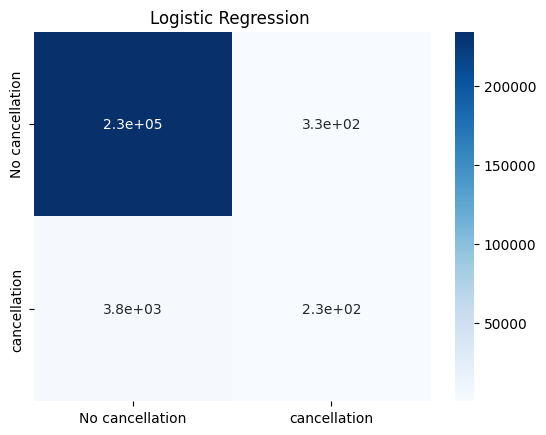

In [198]:
cm=confusion_matrix(y_test, ypred_lr)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Logistic Regression ')

Text(0.5, 1.0, 'Logistic Regression with smote oversampling')

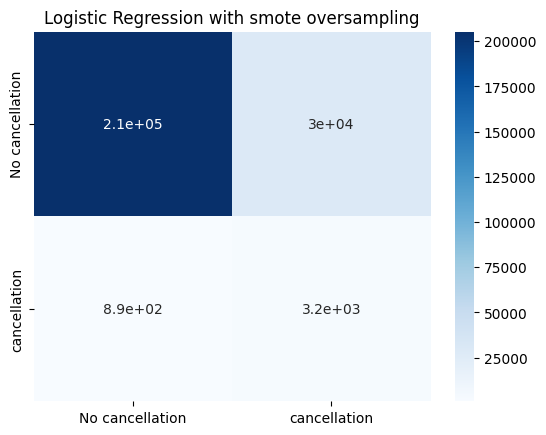

In [199]:
cm=confusion_matrix(y_test, ypred_lr_smote)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Logistic Regression with smote oversampling')

In [200]:
lr_clf_under=LogisticRegression()
lr_clf_under.fit(X_under,y_under)

LogisticRegression()

In [201]:
ypred_lr_under=lr_clf_under.predict(X_test)

In [202]:
print("Accuracy on training set LR_under: {:.3f}".format(lr_clf_under.score(X_under,y_under)))
print("Accuracy on testing set LR_under: {:.3f}".format(accuracy_score(y_test,ypred_lr_under)))
print("Classification report of LR_under:\n", classification_report(y_test,ypred_lr_under))

Accuracy on training set LR_under: 0.835
Accuracy on testing set LR_under: 0.864
Classification report of LR_under:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    234833
           1       0.09      0.80      0.17      4066

    accuracy                           0.86    238899
   macro avg       0.54      0.83      0.55    238899
weighted avg       0.98      0.86      0.91    238899



In [203]:
rf_clf=RandomForestClassifier(n_estimators=50, max_depth=10, random_state=25)

In [204]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=25)

In [205]:
ypred_rf=rf_clf.predict(X_test)

In [206]:
print("Accuracy on training set RF: {:.3f}".format(rf_clf.score(X_train,y_train)))
print("Accuracy on testing set RF: {:.3f}".format(accuracy_score(y_test,ypred_rf)))
print("Classification report of RF:\n", classification_report(y_test,ypred_rf))

Accuracy on training set RF: 0.983
Accuracy on testing set RF: 0.983
Classification report of RF:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    234833
           1       0.48      0.00      0.01      4066

    accuracy                           0.98    238899
   macro avg       0.73      0.50      0.50    238899
weighted avg       0.97      0.98      0.97    238899



Text(0.5, 1.0, 'Randomforest Classifier')

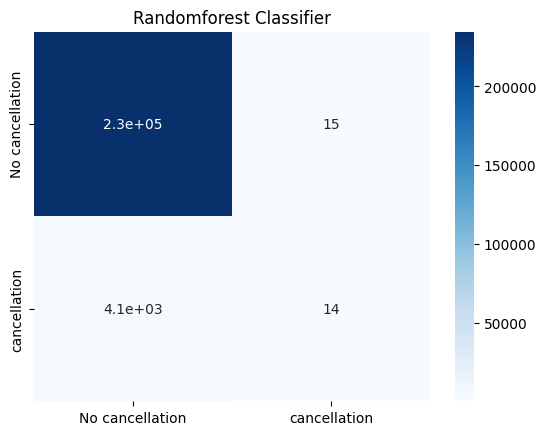

In [207]:
cm=confusion_matrix(y_test, ypred_rf)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Randomforest Classifier')

In [208]:
pickle.dump(rf_clf, open('../models/rf_clf.pkl', 'wb'))


In [209]:
rf_clf_smote=RandomForestClassifier(n_estimators=50, max_depth=10, random_state=25)


In [210]:
rf_clf_smote.fit(X_smote,y_smote)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=25)

In [211]:
ypred_rf_smote=rf_clf_smote.predict(X_test)

In [212]:
print("Accuracy on training set RF_smote: {:.3f}".format(rf_clf_smote.score(X_smote,y_smote)))
print("Accuracy on testing set RF_smote: {:.3f}".format(accuracy_score(y_test,ypred_rf_smote)))
print("Classification report of RF_smote:\n", classification_report(y_test,ypred_rf_smote))

Accuracy on training set RF_smote: 0.937
Accuracy on testing set RF_smote: 0.885
Classification report of RF_smote:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94    234833
           1       0.10      0.70      0.17      4066

    accuracy                           0.88    238899
   macro avg       0.55      0.79      0.55    238899
weighted avg       0.98      0.88      0.92    238899



Text(0.5, 1.0, 'Randomforest Classifier with smote oversampling')

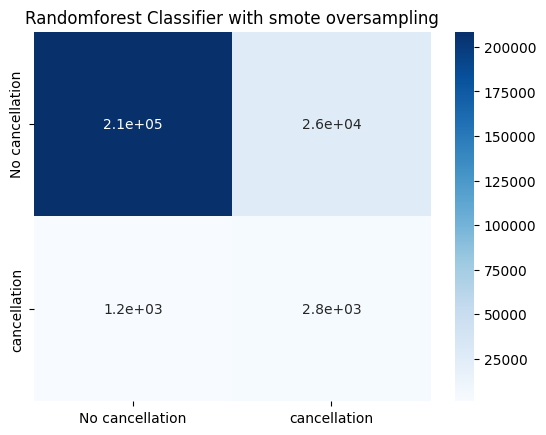

In [213]:
cm=confusion_matrix(y_test, ypred_rf_smote)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Randomforest Classifier with smote oversampling')

In [214]:
pickle.dump(rf_clf_smote, open('../models/rf_clf_smote.pkl', 'wb'))


In [215]:
rf_clf_under=RandomForestClassifier(n_estimators=50, max_depth=10, random_state=25)
rf_clf_under.fit(X_under,y_under)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=25)

In [216]:
ypred_rf_under=rf_clf_under.predict(X_test)

In [217]:
print("Accuracy on training set RF_under: {:.3f}".format(rf_clf_under.score(X_under,y_under)))
print("Accuracy on testing set RF_under: {:.3f}".format(accuracy_score(y_test,ypred_rf_under)))
print("Classification report of RF_under:\n", classification_report(y_test,ypred_rf_under))

Accuracy on training set RF_under: 0.895
Accuracy on testing set RF_under: 0.778
Classification report of RF_under:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87    234833
           1       0.07      0.99      0.13      4066

    accuracy                           0.78    238899
   macro avg       0.54      0.88      0.50    238899
weighted avg       0.98      0.78      0.86    238899



In [218]:
xgb_clf=XGBClassifier()
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [219]:
ypred_xgb=xgb_clf.predict(X_test)

In [220]:
print("Accuracy on training set XGB: {:.3f}".format(xgb_clf.score(X_train,y_train)))
print("Accuracy on testing set XGB: {:.3f}".format(accuracy_score(y_test,ypred_xgb)))
print("Classification report of XGB:\n", classification_report(y_test,ypred_xgb))

Accuracy on training set XGB: 0.984
Accuracy on testing set XGB: 0.983
Classification report of XGB:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    234833
           1       0.43      0.01      0.03      4066

    accuracy                           0.98    238899
   macro avg       0.71      0.51      0.51    238899
weighted avg       0.97      0.98      0.97    238899



Text(0.5, 1.0, 'XGB Classifier')

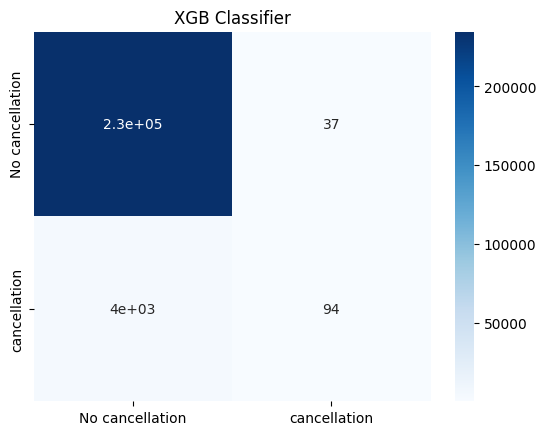

In [58]:
cm=confusion_matrix(y_test, ypred_xgb)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('XGB Classifier')

In [86]:
pickle.dump(xgb_clf, open('../models/xgb_clf.pkl', 'wb'))


In [87]:
xgb_clf_smote=XGBClassifier()
xgb_clf_smote.fit(X_smote,y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [88]:
ypred_xgb_smote=xgb_clf_smote.predict(X_test)

In [89]:
print("Accuracy on training set XGB_smote: {:.3f}".format(xgb_clf_smote.score(X_smote,y_smote)))
print("Accuracy on testing set XGB_smote: {:.3f}".format(accuracy_score(y_test,ypred_xgb_smote)))
print("Classification report of XGB_smote:\n", classification_report(y_test,ypred_xgb_smote))

Accuracy on training set XGB_smote: 0.991
Accuracy on testing set XGB_smote: 0.983
Classification report of XGB_smote:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    234833
           1       0.17      0.00      0.00      4066

    accuracy                           0.98    238899
   macro avg       0.58      0.50      0.50    238899
weighted avg       0.97      0.98      0.97    238899



In [90]:
pickle.dump(xgb_clf_smote, open('../models/xgb_clf_smote.pkl', 'wb'))


Text(0.5, 1.0, 'XGB Classifier with smote oversampling')

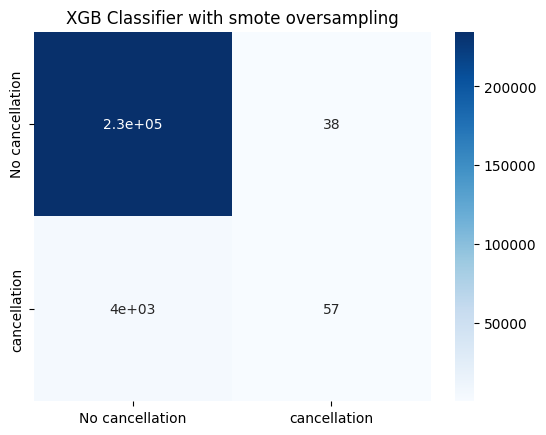

In [62]:
cm=confusion_matrix(y_test, ypred_xgb_smote)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('XGB Classifier with smote oversampling')

In [100]:
xgb_clf_under=XGBClassifier()
xgb_clf_under.fit(X_under,y_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [101]:
ypred_xgb_under=xgb_clf_under.predict(X_test)

In [102]:
print("Accuracy on training set XGB_under: {:.3f}".format(xgb_clf_under.score(X_under,y_under)))
print("Accuracy on testing set XGB_under: {:.3f}".format(accuracy_score(y_test,ypred_xgb_under)))
print("Classification report of XGB_under:\n", classification_report(y_test,ypred_xgb_under))

Accuracy on training set XGB_under: 0.842
Accuracy on testing set XGB_under: 0.657
Classification report of XGB_under:
               precision    recall  f1-score   support

           0       0.99      0.66      0.79    234833
           1       0.04      0.77      0.07      4066

    accuracy                           0.66    238899
   macro avg       0.52      0.71      0.43    238899
weighted avg       0.98      0.66      0.78    238899



In [222]:
#resampling manually

In [224]:
df_can = df_clf[df_clf.cancelled == 1 ]
df_nocan = df_clf[df_clf.cancelled == 0 ]
df_nocan = df_nocan.sample(n=13404, random_state=10)
df_half = pd.concat([df_can,df_nocan])
df_half = shuffle(df_half)

In [225]:
X=df_half[['mkt_carrier_fl_num','distance', 'month', 
       'carrier_origin_vol', 'carrier_dest_vol', 'carrier_cancel',
       'carrier_month_cancel', 'carrier_season_cancel',
       'carrier_dep_hour_cancel', 'origin_cancel', 'dest_cancel',
       'route_cancel', 'origin_month_cancellation', 'dest_month_cancellation',
       'route_month_cancellation']]
y = df_half.cancelled

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12)

In [227]:
lr_clf=LogisticRegression()
rf_clf=RandomForestClassifier(n_estimators=50, max_depth=10, random_state=25)
xgb_clf=XGBClassifier()


In [228]:
lr_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
xgb_clf.fit(X_train,y_train)

/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [229]:
ypred_lr=lr_clf.predict(X_test)
ypred_rf=rf_clf.predict(X_test)
ypred_xgb=xgb_clf.predict(X_test)

In [230]:
print("Accuracy on training set LR: {:.3f}".format(lr_clf.score(X_train,y_train)))
print("Accuracy on testing set LR: {:.3f}".format(accuracy_score(y_test,ypred_lr)))
print("Classification report of LR:\n", classification_report(y_test,ypred_lr))
print("Accuracy on training set RF: {:.3f}".format(rf_clf.score(X_train,y_train)))
print("Accuracy on testing set RF: {:.3f}".format(accuracy_score(y_test,ypred_rf)))
print("Classification report of RF:\n", classification_report(y_test,ypred_rf))
print("Accuracy on training set XGB: {:.3f}".format(xgb_clf.score(X_train,y_train)))
print("Accuracy on testing set XGB: {:.3f}".format(accuracy_score(y_test,ypred_xgb)))
print("Classification report of XGB:\n", classification_report(y_test,ypred_xgb))

Accuracy on training set LR: 0.836
Accuracy on testing set LR: 0.838
Classification report of LR:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      4051
           1       0.85      0.81      0.83      3992

    accuracy                           0.84      8043
   macro avg       0.84      0.84      0.84      8043
weighted avg       0.84      0.84      0.84      8043

Accuracy on training set RF: 0.898
Accuracy on testing set RF: 0.878
Classification report of RF:
               precision    recall  f1-score   support

           0       0.97      0.78      0.87      4051
           1       0.81      0.98      0.89      3992

    accuracy                           0.88      8043
   macro avg       0.89      0.88      0.88      8043
weighted avg       0.89      0.88      0.88      8043

Accuracy on training set XGB: 0.933
Accuracy on testing set XGB: 0.871
Classification report of XGB:
               precision    recall  f1-score   

In [231]:
pickle.dump(lr_clf, open('../models/lr_clf_sampling.pkl', 'wb'))
pickle.dump(rf_clf, open('../models/rf_clf_sampling.pkl', 'wb'))
pickle.dump(xgb_clf, open('../models/xgb_clf_sampling.pkl', 'wb'))


### Multi class classification to find the type of the delay

In [262]:
df_multi=flights_train[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time','dep_delay',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance','arr_delay','carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay','cancelled','taxi_in', 'taxi_out','diverted']].copy()

In [263]:
missing_values = df_multi.isnull().sum().sort_values(ascending=False)
missing_values

late_aircraft_delay    645775
security_delay         645775
nas_delay              645775
weather_delay          645775
carrier_delay          645775
arr_delay               15508
taxi_in                 13983
taxi_out                13591
dep_delay               13147
tail_num                 2514
crs_elapsed_time            2
crs_arr_time                0
cancelled                   0
distance                    0
flights                     0
dup                         0
fl_date                     0
mkt_unique_carrier          0
crs_dep_time                0
dest_city_name              0
dest                        0
dest_airport_id             0
origin_city_name            0
origin                      0
origin_airport_id           0
op_carrier_fl_num           0
op_unique_carrier           0
mkt_carrier_fl_num          0
mkt_carrier                 0
branded_code_share          0
diverted                    0
dtype: int64

In [264]:
multi_target_cols = ['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']
df_multi['largest_target_delay'] = df_multi[multi_target_cols].idxmax(axis="columns")
df_multi

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,taxi_in,taxi_out,diverted,largest_target_delay
0,2018-09-20,DL,DL_CODESHARE,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",731,-8.0,749,N,78.0,1,300,-17.0,NaN,NaN,NaN,NaN,NaN,0,5.0,6.0,0,NaN
1,2018-09-20,DL,DL_CODESHARE,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",528,-11.0,613,N,45.0,1,69,-16.0,NaN,NaN,NaN,NaN,NaN,0,7.0,14.0,0,NaN
2,2018-09-20,DL,DL_CODESHARE,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,-9.0,1309,N,84.0,1,320,-13.0,NaN,NaN,NaN,NaN,NaN,0,5.0,13.0,0,NaN
3,2018-09-20,DL,DL_CODESHARE,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,-7.0,1635,N,85.0,1,349,-18.0,NaN,NaN,NaN,NaN,NaN,0,10.0,7.0,0,NaN
4,2018-09-20,DL,DL_CODESHARE,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,5.0,20.0,0,late_aircraft_delay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796323,2018-09-20,UA,UA_CODESHARE,UA,5853,OO,N144SY,5853,11503,EGE,"Eagle, CO",11292,DEN,"Denver, CO",1320,-7.0,1423,N,63.0,1,120,-17.0,NaN,NaN,NaN,NaN,NaN,0,8.0,14.0,0,NaN
796324,2018-09-20,UA,UA_CODESHARE,UA,5895,OO,N790SK,5895,12892,LAX,"Los Angeles, CA",10372,ASE,"Aspen, CO",950,21.0,1302,N,132.0,1,737,3.0,NaN,NaN,NaN,NaN,NaN,0,3.0,19.0,0,NaN
796325,2018-09-20,UA,UA_CODESHARE,UA,5913,OO,N119SY,5913,14869,SLC,"Salt Lake City, UT",11292,DEN,"Denver, CO",900,-5.0,1037,N,97.0,1,391,-14.0,NaN,NaN,NaN,NaN,NaN,0,12.0,11.0,0,NaN
796326,2018-09-20,UA,UA_CODESHARE,UA,5926,OO,N784SK,5926,13930,ORD,"Chicago, IL",11003,CID,"Cedar Rapids/Iowa City, IA",746,-8.0,856,N,70.0,1,196,12.0,NaN,NaN,NaN,NaN,NaN,0,5.0,43.0,0,NaN


In [265]:
df_multi['largest_target_delay'].value_counts()

late_aircraft_delay    59163
nas_delay              45728
carrier_delay          40361
weather_delay           5074
security_delay           227
Name: largest_target_delay, dtype: int64

In [266]:
delay_dict = {'late_aircraft_delay':1, 'nas_delay':2, 'carrier_delay':3, 'weather_delay':4, 'security_delay':5}
df_multi['largest_target_delay'] = df_multi['largest_target_delay'].map(delay_dict)

In [267]:
df_multi

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,taxi_in,taxi_out,diverted,largest_target_delay
0,2018-09-20,DL,DL_CODESHARE,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",731,-8.0,749,N,78.0,1,300,-17.0,NaN,NaN,NaN,NaN,NaN,0,5.0,6.0,0,NaN
1,2018-09-20,DL,DL_CODESHARE,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",528,-11.0,613,N,45.0,1,69,-16.0,NaN,NaN,NaN,NaN,NaN,0,7.0,14.0,0,NaN
2,2018-09-20,DL,DL_CODESHARE,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,-9.0,1309,N,84.0,1,320,-13.0,NaN,NaN,NaN,NaN,NaN,0,5.0,13.0,0,NaN
3,2018-09-20,DL,DL_CODESHARE,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,-7.0,1635,N,85.0,1,349,-18.0,NaN,NaN,NaN,NaN,NaN,0,10.0,7.0,0,NaN
4,2018-09-20,DL,DL_CODESHARE,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,5.0,20.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796323,2018-09-20,UA,UA_CODESHARE,UA,5853,OO,N144SY,5853,11503,EGE,"Eagle, CO",11292,DEN,"Denver, CO",1320,-7.0,1423,N,63.0,1,120,-17.0,NaN,NaN,NaN,NaN,NaN,0,8.0,14.0,0,NaN
796324,2018-09-20,UA,UA_CODESHARE,UA,5895,OO,N790SK,5895,12892,LAX,"Los Angeles, CA",10372,ASE,"Aspen, CO",950,21.0,1302,N,132.0,1,737,3.0,NaN,NaN,NaN,NaN,NaN,0,3.0,19.0,0,NaN
796325,2018-09-20,UA,UA_CODESHARE,UA,5913,OO,N119SY,5913,14869,SLC,"Salt Lake City, UT",11292,DEN,"Denver, CO",900,-5.0,1037,N,97.0,1,391,-14.0,NaN,NaN,NaN,NaN,NaN,0,12.0,11.0,0,NaN
796326,2018-09-20,UA,UA_CODESHARE,UA,5926,OO,N784SK,5926,13930,ORD,"Chicago, IL",11003,CID,"Cedar Rapids/Iowa City, IA",746,-8.0,856,N,70.0,1,196,12.0,NaN,NaN,NaN,NaN,NaN,0,5.0,43.0,0,NaN


In [268]:
df_multi=convert_time(df_multi)
df_multi=bins(df_multi)
df_multi

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,taxi_in,taxi_out,diverted,largest_target_delay,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season
0,2018-09-20,DL,DL_CODESHARE,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",0731,-8.0,0749,N,78.0,1,300,-17.0,NaN,NaN,NaN,NaN,NaN,0,5.0,6.0,0,NaN,9,20,263,3,07,07,1,1,4
1,2018-09-20,DL,DL_CODESHARE,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",0528,-11.0,0613,N,45.0,1,69,-16.0,NaN,NaN,NaN,NaN,NaN,0,7.0,14.0,0,NaN,9,20,263,3,05,06,0,1,4
2,2018-09-20,DL,DL_CODESHARE,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,-9.0,1309,N,84.0,1,320,-13.0,NaN,NaN,NaN,NaN,NaN,0,5.0,13.0,0,NaN,9,20,263,3,11,13,2,2,4
3,2018-09-20,DL,DL_CODESHARE,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,-7.0,1635,N,85.0,1,349,-18.0,NaN,NaN,NaN,NaN,NaN,0,10.0,7.0,0,NaN,9,20,263,3,15,16,2,2,4
4,2018-09-20,DL,DL_CODESHARE,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,5.0,20.0,0,1.0,9,20,263,3,21,22,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796323,2018-09-20,UA,UA_CODESHARE,UA,5853,OO,N144SY,5853,11503,EGE,"Eagle, CO",11292,DEN,"Denver, CO",1320,-7.0,1423,N,63.0,1,120,-17.0,NaN,NaN,NaN,NaN,NaN,0,8.0,14.0,0,NaN,9,20,263,3,13,14,2,2,4
796324,2018-09-20,UA,UA_CODESHARE,UA,5895,OO,N790SK,5895,12892,LAX,"Los Angeles, CA",10372,ASE,"Aspen, CO",0950,21.0,1302,N,132.0,1,737,3.0,NaN,NaN,NaN,NaN,NaN,0,3.0,19.0,0,NaN,9,20,263,3,09,13,1,2,4
796325,2018-09-20,UA,UA_CODESHARE,UA,5913,OO,N119SY,5913,14869,SLC,"Salt Lake City, UT",11292,DEN,"Denver, CO",0900,-5.0,1037,N,97.0,1,391,-14.0,NaN,NaN,NaN,NaN,NaN,0,12.0,11.0,0,NaN,9,20,263,3,09,10,1,1,4
796326,2018-09-20,UA,UA_CODESHARE,UA,5926,OO,N784SK,5926,13930,ORD,"Chicago, IL",11003,CID,"Cedar Rapids/Iowa City, IA",0746,-8.0,0856,N,70.0,1,196,12.0,NaN,NaN,NaN,NaN,NaN,0,5.0,43.0,0,NaN,9,20,263,3,07,08,1,1,4


In [269]:
def stats_hist_delay(df):
   # df['origin_airport_vol'] = df.groupby(['origin_airport_id'])['flights'].transform(np.sum)
   # df['dest_airport_vol'] = df.groupby(['dest_airport_id'])['flights'].transform(np.sum)
    df['carrier_origin_vol'] = df.groupby(['origin_airport_id','op_unique_carrier'])['flights'].transform(np.sum)
    df['carrier_dest_vol'] = df.groupby(['dest_airport_id','op_unique_carrier'])['flights'].transform(np.sum)

   # df['carrier_origin'] = df['carrier_origin_vol'] / df['origin_airport_vol'] * 100
   # df['carrier_dest'] = df['carrier_dest_vol'] / df['dest_airport_vol'] * 100
    df['mean_carrier_arrdelay_month']=df.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.mean)
    df['median_carrier_arrdelay_month']=df.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.median)
    df['mean_carrier_origin_dep_hour_dep_delay'] = df.groupby(['op_unique_carrier','origin','dep_hour'])['dep_delay'].transform(np.mean)
    df['mean_carrier_dest_arr_hour_delay'] = df.groupby(['op_unique_carrier','dest','arr_hour'])['arr_delay'].transform(np.mean)    
    df['median_carrier_origin_dep_hour_dep_delay'] = df.groupby(['op_unique_carrier','origin','dep_hour'])['dep_delay'].transform(np.median)
    df['median_carrier_dest_arr_hour_arr_delay'] = df.groupby(['op_unique_carrier','dest','arr_hour'])['arr_delay'].transform(np.median)    

    df['mean_route_arr_delay_dep_hour'] = df.groupby(['origin','dest','dep_part_day'])['arr_delay'].transform(np.mean)
    df['mean_route_dep_delay_dep_hour'] = df.groupby(['origin','dest','dep_part_day'])['dep_delay'].transform(np.mean)
    df['median_route_arr_delay_dep_hour'] = df.groupby(['origin','dest','dep_part_day'])['arr_delay'].transform(np.median)
    df['median_route_dep_delay_dep_hour'] = df.groupby(['origin','dest','dep_part_day'])['dep_delay'].transform(np.median)

    df['mean_route_arr_delay_arr_hour'] = df.groupby(['origin','dest','arr_part_day'])['arr_delay'].transform(np.mean)
    df['mean_route_dep_delay_arr_hour'] = df.groupby(['origin','dest','arr_part_day'])['dep_delay'].transform(np.mean)
    df['median_route_arr_delay_arr_hour'] = df.groupby(['origin','dest','arr_part_day'])['arr_delay'].transform(np.median)
    df['median_route_dep_delay_arr_hour'] = df.groupby(['origin','dest','arr_part_day'])['dep_delay'].transform(np.median)

    
    #cancel_hist=df[['carrier_cancel','carrier_month_cancel','carrier_dow_cancel','carrier_dep_part_day_cancel','carrier_season_cancel','carrier_dep_hour_cancel','origin_cancel','dest_cancel','route_cancel']]
    return df

In [270]:
df_multi=stats_hist_delay(df_multi)
df_multi

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,taxi_in,taxi_out,diverted,largest_target_delay,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season,carrier_origin_vol,carrier_dest_vol,mean_carrier_arrdelay_month,median_carrier_arrdelay_month,mean_carrier_origin_dep_hour_dep_delay,mean_carrier_dest_arr_hour_delay,median_carrier_origin_dep_hour_dep_delay,median_carrier_dest_arr_hour_arr_delay,mean_route_arr_delay_dep_hour,mean_route_dep_delay_dep_hour,median_route_arr_delay_dep_hour,median_route_dep_delay_dep_hour,mean_route_arr_delay_arr_hour,mean_route_dep_delay_arr_hour,median_route_arr_delay_arr_hour,median_route_dep_delay_arr_hour
0,2018-09-20,DL,DL_CODESHARE,DL,7362,OO,N8942A,7362,13459,MQT,"Marquette, MI",13487,MSP,"Minneapolis, MN",0731,-8.0,0749,N,78.0,1,300,-17.0,NaN,NaN,NaN,NaN,NaN,0,5.0,6.0,0,NaN,9,20,263,3,07,07,1,1,4,120,4739,2.703907,-8.0,13.760870,5.852410,-5.0,-7.5,6.000000,13.760870,-12.0,-5.0,6.000000,13.760870,-12.0,-5.0
1,2018-09-20,DL,DL_CODESHARE,DL,7369,OO,N429SW,7369,10333,APN,"Alpena, MI",14150,PLN,"Pellston, MI",0528,-11.0,0613,N,45.0,1,69,-16.0,NaN,NaN,NaN,NaN,NaN,0,7.0,14.0,0,NaN,9,20,263,3,05,06,0,1,4,51,91,2.703907,-8.0,58.235294,44.000000,-4.0,-15.0,49.941176,58.235294,-14.0,-4.0,44.000000,51.333333,-15.0,-6.5
2,2018-09-20,DL,DL_CODESHARE,DL,7383,OO,N979EV,7383,11122,CPR,"Casper, WY",14869,SLC,"Salt Lake City, UT",1145,-9.0,1309,N,84.0,1,320,-13.0,NaN,NaN,NaN,NaN,NaN,0,5.0,13.0,0,NaN,9,20,263,3,11,13,2,2,4,111,4438,2.703907,-8.0,-0.658537,2.950355,-5.0,-9.0,-4.027027,0.108108,-9.0,-5.0,-4.027027,0.108108,-9.0,-5.0
3,2018-09-20,DL,DL_CODESHARE,DL,7406,OO,N429SW,7406,13459,MQT,"Marquette, MI",11433,DTW,"Detroit, MI",1510,-7.0,1635,N,85.0,1,349,-18.0,NaN,NaN,NaN,NaN,NaN,0,10.0,7.0,0,NaN,9,20,263,3,15,16,2,2,4,120,4214,2.703907,-8.0,8.888889,4.311828,-9.0,-9.0,-1.852941,6.000000,-12.5,-4.0,-3.545455,4.045455,-13.0,-4.0
4,2018-09-20,DL,DL_CODESHARE,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,5.0,20.0,0,1.0,9,20,263,3,21,22,4,4,4,107,67,2.703907,-8.0,-3.300000,-11.315789,-11.0,-19.0,-12.142857,-7.428571,-19.0,-12.0,-12.142857,-7.428571,-19.0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796323,2018-09-20,UA,UA_CODESHARE,UA,5853,OO,N144SY,5853,11503,EGE,"Eagle, CO",11292,DEN,"Denver, CO",1320,-7.0,1423,N,63.0,1,120,-17.0,NaN,NaN,NaN,NaN,NaN,0,8.0,14.0,0,NaN,9,20,263,3,13,14,2,2,4,65,4892,2.703907,-8.0,-1.750000,5.895327,-9.0,-8.0,27.195122,34.146341,-17.0,-8.0,29.666667,36.410256,-17.0,-8.0
796324,2018-09-20,UA,UA_CODESHARE,UA,5895,OO,N790SK,5895,12892,LAX,"Los Angeles, CA",10372,ASE,"Aspen, CO",0950,21.0,1302,N,132.0,1,737,3.0,NaN,NaN,NaN,NaN,NaN,0,3.0,19.0,0,NaN,9,20,263,3,09,13,1,2,4,3311,656,2.703907,-8.0,5.277045,-1.361111,-4.0,-6.0,6.025641,14.363636,-12.0,-3.0,7.553571,15.081967,-9.5,-3.0
796325,2018-09-20,UA,UA_CODESHARE,UA,5913,OO,N119SY,5913,14869,SLC,"Salt Lake City, UT",11292,DEN,"Denver, CO",0900,-5.0,1037,N,97.0,1,391,-14.0,NaN,NaN,NaN,NaN,NaN,0,12.0,11.0,0,NaN,9,20,263,3,09,10,1,1,4,4402,4892,2.703907,-8.0,1.743662,12.058455,-4.0,-5.0,-2.561538,3.369231,-9.0,-4.0,-3.039648,2.453744,-10.0,-5.0
796326,2018-09-20,UA,UA_CODESHARE,UA,5926,OO,N784SK,5926,13930,ORD,"Chicago, IL",11003,CID,"Cedar Rapids/Iowa City, IA",0746,-8.0,0856,N,70.0,1,196,12.0,NaN,NaN,NaN,NaN,NaN,0,5.0,43.0,0,NaN,9,20,263,3,07,08,1,1,4,6748,279,2.703907,-8.0,7.867416,4.875000,-4.0,-0.5,2.988095,6.690476,-6.5,

In [271]:
df_multi=df_multi.dropna()
df_multi

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,taxi_in,taxi_out,diverted,largest_target_delay,month,day,day_of_year,day_of_week,dep_hour,arr_hour,dep_part_day,arr_part_day,season,carrier_origin_vol,carrier_dest_vol,mean_carrier_arrdelay_month,median_carrier_arrdelay_month,mean_carrier_origin_dep_hour_dep_delay,mean_carrier_dest_arr_hour_delay,median_carrier_origin_dep_hour_dep_delay,median_carrier_dest_arr_hour_arr_delay,mean_route_arr_delay_dep_hour,mean_route_dep_delay_dep_hour,median_route_arr_delay_dep_hour,median_route_dep_delay_dep_hour,mean_route_arr_delay_arr_hour,mean_route_dep_delay_arr_hour,median_route_arr_delay_arr_hour,median_route_dep_delay_arr_hour
4,2018-09-20,DL,DL_CODESHARE,DL,7408,OO,N465SW,7408,14150,PLN,"Pellston, MI",10333,APN,"Alpena, MI",2150,57.0,2229,N,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,5.0,20.0,0,1.0,9,20,263,3,21,22,4,4,4,107,67,2.703907,-8.0,-3.300000,-11.315789,-11.0,-19.0,-12.142857,-7.428571,-19.0,-12.0,-12.142857,-7.428571,-19.0,-12.0
9,2018-09-21,AA,AA,AA,1198,AA,N154AA,1198,14771,SFO,"San Francisco, CA",11298,DFW,"Dallas/Fort Worth, TX",0607,-7.0,1143,N,216.0,1,1464,27.0,0.0,0.0,27.0,0.0,0.0,0,9.0,35.0,0,2.0,9,21,264,4,06,11,1,2,4,1330,14897,3.134631,-7.0,4.420168,2.398529,-4.0,-7.0,0.656627,4.757396,-8.0,-3.0,0.028571,4.331461,-8.0,-3.0
15,2018-09-21,AA,AA,AA,1328,AA,N826NN,1328,11298,DFW,"Dallas/Fort Worth, TX",11109,COS,"Colorado Springs, CO",1450,42.0,1544,N,114.0,1,592,54.0,42.0,0.0,12.0,0.0,0.0,0,7.0,29.0,0,3.0,9,21,264,4,14,15,2,2,4,14921,137,3.134631,-7.0,15.180732,16.764706,1.0,-1.5,17.081633,15.489796,2.0,-1.0,14.953488,14.046512,-1.0,-1.0
18,2018-09-21,AA,AA,AA,2535,AA,N994AN,2535,14679,SAN,"San Diego, CA",11298,DFW,"Dallas/Fort Worth, TX",0628,-4.0,1137,N,189.0,1,1171,23.0,0.0,0.0,23.0,0.0,0.0,0,11.0,35.0,0,2.0,9,21,264,4,06,11,1,2,4,893,14897,3.134631,-7.0,-1.213592,2.398529,-4.0,-7.0,-2.992806,3.390071,-10.0,-3.0,-1.717791,4.206061,-10.0,-3.0
20,2018-09-21,AA,AA,AA,2566,AA,N164NN,2566,11298,DFW,"Dallas/Fort Worth, TX",14869,SLC,"Salt Lake City, UT",1650,24.0,1831,N,161.0,1,989,21.0,0.0,0.0,0.0,0.0,21.0,0,4.0,19.0,0,1.0,9,21,264,4,16,18,2,3,4,14921,464,3.134631,-7.0,16.818991,23.235294,2.0,3.5,12.317241,16.212329,-1.0,-1.0,22.321429,26.210526,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796300,2018-09-20,UA,UA_CODESHARE,UA,5277,OO,N969SW,5277,13930,ORD,"Chicago, IL",10980,CHA,"Chattanooga, TN",1413,53.0,1700,N,107.0,1,501,55.0,53.0,0.0,2.0,0.0,0.0,0,4.0,30.0,0,3.0,9,20,263,3,14,17,2,3,4,6748,290,2.703907,-8.0,17.568035,21.107143,-2.0,2.0,19.718310,20.873239,0.0,-2.0,26.636364,24.409091,6.0,6.5
796306,2018-09-20,UA,UA_CODESHARE,UA,5431,OO,N932SW,5431,13342,MKE,"Milwaukee, WI",13930,ORD,"Chicago, IL",1752,21.0,1850,N,58.0,1,67,26.0,0.0,0.0,5.0,0.0,21.0,0,17.0,18.0,0,1.0,9,20,263,3,17,18,3,3,4,493,6786,2.703907,-8.0,20.206897,34.135231,0.0,1.0,26.444444,25.555556,-1.0,-3.0,21.367347,18.877551,-3.0,-3.0
796307,2018-09-20,UA,UA_CODESHARE,UA,5456,OO,N787SK,5456,12266,IAH,"Houston, TX",11057,CLT,"Charlotte, NC",1230,14.0,1557,N,147.0,1,912,48.0,0.0,7.0,34.0,0.0,7.0,0,14.0,40.0,0,2.0,9,20,263,3,12,15,2,2,4,943,264,2.703907,-8.0,10.971963,-2.810811,-2.0,-3.0,1.375000,5.089286,-7.0,-2.5,-0.292994,3.420382,-6.0,-4.0
796309,2018-09-20,UA,UA_CODESHARE,UA,5477,OO,N917SW,5477,10785,BTV,"Burlington, VT",13930,ORD,"Chicago, IL",1005,6.0,1137,N,152.0,1,763,18.0,6.0,0.0,12.0,0.0,0.0,0,15.0,18.0,0,2.0,9,20,263,3,10,11,1,2,4,59,6786,2.703907,-8.0,-3.187500,1.770241,-5.0,-10.0,-3.519481,0.2

In [272]:
df_multi = df_multi.select_dtypes('number')
df_multi

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,dep_delay,crs_elapsed_time,flights,distance,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,taxi_in,taxi_out,diverted,largest_target_delay,month,day,day_of_year,day_of_week,dep_part_day,arr_part_day,season,carrier_origin_vol,carrier_dest_vol,mean_carrier_arrdelay_month,median_carrier_arrdelay_month,mean_carrier_origin_dep_hour_dep_delay,mean_carrier_dest_arr_hour_delay,median_carrier_origin_dep_hour_dep_delay,median_carrier_dest_arr_hour_arr_delay,mean_route_arr_delay_dep_hour,mean_route_dep_delay_dep_hour,median_route_arr_delay_dep_hour,median_route_dep_delay_dep_hour,mean_route_arr_delay_arr_hour,mean_route_dep_delay_arr_hour,median_route_arr_delay_arr_hour,median_route_dep_delay_arr_hour
4,7408,7408,14150,10333,57.0,39.0,1,69,73.0,0.0,0.0,16.0,0.0,57.0,0,5.0,20.0,0,1.0,9,20,263,3,4,4,4,107,67,2.703907,-8.0,-3.300000,-11.315789,-11.0,-19.0,-12.142857,-7.428571,-19.0,-12.0,-12.142857,-7.428571,-19.0,-12.0
9,1198,1198,14771,11298,-7.0,216.0,1,1464,27.0,0.0,0.0,27.0,0.0,0.0,0,9.0,35.0,0,2.0,9,21,264,4,1,2,4,1330,14897,3.134631,-7.0,4.420168,2.398529,-4.0,-7.0,0.656627,4.757396,-8.0,-3.0,0.028571,4.331461,-8.0,-3.0
15,1328,1328,11298,11109,42.0,114.0,1,592,54.0,42.0,0.0,12.0,0.0,0.0,0,7.0,29.0,0,3.0,9,21,264,4,2,2,4,14921,137,3.134631,-7.0,15.180732,16.764706,1.0,-1.5,17.081633,15.489796,2.0,-1.0,14.953488,14.046512,-1.0,-1.0
18,2535,2535,14679,11298,-4.0,189.0,1,1171,23.0,0.0,0.0,23.0,0.0,0.0,0,11.0,35.0,0,2.0,9,21,264,4,1,2,4,893,14897,3.134631,-7.0,-1.213592,2.398529,-4.0,-7.0,-2.992806,3.390071,-10.0,-3.0,-1.717791,4.206061,-10.0,-3.0
20,2566,2566,11298,14869,24.0,161.0,1,989,21.0,0.0,0.0,0.0,0.0,21.0,0,4.0,19.0,0,1.0,9,21,264,4,2,3,4,14921,464,3.134631,-7.0,16.818991,23.235294,2.0,3.5,12.317241,16.212329,-1.0,-1.0,22.321429,26.210526,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796300,5277,5277,13930,10980,53.0,107.0,1,501,55.0,53.0,0.0,2.0,0.0,0.0,0,4.0,30.0,0,3.0,9,20,263,3,2,3,4,6748,290,2.703907,-8.0,17.568035,21.107143,-2.0,2.0,19.718310,20.873239,0.0,-2.0,26.636364,24.409091,6.0,6.5
796306,5431,5431,13342,13930,21.0,58.0,1,67,26.0,0.0,0.0,5.0,0.0,21.0,0,17.0,18.0,0,1.0,9,20,263,3,3,3,4,493,6786,2.703907,-8.0,20.206897,34.135231,0.0,1.0,26.444444,25.555556,-1.0,-3.0,21.367347,18.877551,-3.0,-3.0
796307,5456,5456,12266,11057,14.0,147.0,1,912,48.0,0.0,7.0,34.0,0.0,7.0,0,14.0,40.0,0,2.0,9,20,263,3,2,2,4,943,264,2.703907,-8.0,10.971963,-2.810811,-2.0,-3.0,1.375000,5.089286,-7.0,-2.5,-0.292994,3.420382,-6.0,-4.0
796309,5477,5477,10785,13930,6.0,152.0,1,763,18.0,6.0,0.0,12.0,0.0,0.0,0,15.0,18.0,0,2.0,9,20,263,3,1,2,4,59,6786,2.703907,-8.0,-3.187500,1.770241,-5.0,-10.0,-3.519481,0.285714,-9.0,-6.0,-3.413043,7.446809,-5.5,-2.0


In [273]:
df_multi.columns

Index(['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id',
       'dest_airport_id', 'dep_delay', 'crs_elapsed_time', 'flights',
       'distance', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'cancelled', 'taxi_in',
       'taxi_out', 'diverted', 'largest_target_delay', 'month', 'day',
       'day_of_year', 'day_of_week', 'dep_part_day', 'arr_part_day', 'season',
       'carrier_origin_vol', 'carrier_dest_vol', 'mean_carrier_arrdelay_month',
       'median_carrier_arrdelay_month',
       'mean_carrier_origin_dep_hour_dep_delay',
       'mean_carrier_dest_arr_hour_delay',
       'median_carrier_origin_dep_hour_dep_delay',
       'median_carrier_dest_arr_hour_arr_delay',
       'mean_route_arr_delay_dep_hour', 'mean_route_dep_delay_dep_hour',
       'median_route_arr_delay_dep_hour', 'median_route_dep_delay_dep_hour',
       'mean_route_arr_delay_arr_hour', 'mean_route_dep_delay_arr_hour',
       'median_route_ar

In [274]:
X=df_multi[['mkt_carrier_fl_num', 'crs_elapsed_time',
       'taxi_out', 'dep_part_day', 'arr_part_day',
       'carrier_origin_vol', 'carrier_dest_vol', 'mean_carrier_arrdelay_month',
       'median_carrier_arrdelay_month',
       'mean_carrier_origin_dep_hour_dep_delay',
       'mean_carrier_dest_arr_hour_delay',
       'median_carrier_origin_dep_hour_dep_delay',
       'median_carrier_dest_arr_hour_arr_delay',
       'mean_route_arr_delay_dep_hour', 'mean_route_dep_delay_dep_hour',
       'median_route_arr_delay_dep_hour', 'median_route_dep_delay_dep_hour',
       'mean_route_arr_delay_arr_hour', 'mean_route_dep_delay_arr_hour',
       'median_route_arr_delay_arr_hour', 'median_route_dep_delay_arr_hour']]
y=df_multi.largest_target_delay

'mkt_carrier_fl_num', 'origin_airport_id', 'crs_elapsed_time',
       'taxi_out', 'dep_daysection', 'arr_daysection', 'origin_airport_vol',
       'carrier_origin_apt_vol', 'carrier_dest_apt_vol',
       'carrier_origin_apt_pct', 'carrier_dest_apt_pct',
       'mean_carrier_arr_delay_month',
       'mean_carrier_origin_dep-hour_dep_delay',
       'mean_carrier_dest_fl-hour_delay',
       'median_carrier_origin_dep-hour_dep_delay',
       'median_carrier_dest_fl-hour_delay', 'mean_route_arr_delay_dep_hour',
       'mean_route_arr_delay_arr_hour', 'median_route_arr_delay_dep_hour',
       'median_route_dep_delay_dep_hour', 'median_route_arr_delay_arr_hour',
       'median_route_dep_delay_arr_hour', 'route_month_weather_delay_pct',
       'arr_daysection_carrier_delay_pct', 'arr_daysection_nas_delay_pct',
       'dep_daysection_nas_delay_pct', 'carrier_late_aircraft_delay_pct',
       'carrier_route_month_carrier_delay',
       'carrier_route_month_late_aircraft_delay',
       'route_month_weekday_daysection_nas_delay'

In [275]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=15,stratify=y)


In [277]:
lr_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_multi.fit(X_train, y_train)

/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [278]:
ypred_lr_multi=lr_multi.predict(X_test)

In [279]:
print("Accuracy on training set LR: {:.3f}".format(lr_multi.score(X_train,y_train)))
print("Accuracy on testing set LR: {:.3f}".format(accuracy_score(y_test,ypred_lr_multi)))
print("Classification report of LR:\n", classification_report(y_test,ypred_lr_multi))


Accuracy on training set LR: 0.492
Accuracy on testing set LR: 0.494
Classification report of LR:
               precision    recall  f1-score   support

         1.0       0.48      0.81      0.60     17737
         2.0       0.55      0.49      0.52     13712
         3.0       0.43      0.09      0.15     12103
         4.0       0.00      0.00      0.00      1522
         5.0       0.00      0.00      0.00        68

    accuracy                           0.49     45142
   macro avg       0.29      0.28      0.25     45142
weighted avg       0.47      0.49      0.43     45142



/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/phanisingaraju/opt/anaconda3/envs/flights_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [280]:
pickle.dump(lr_multi, open('../models/lr_multi.pkl', 'wb'))
